In [6]:
import os
import re
import SMBcorr
import h5py
import numpy as np
import pointCollection as pc
import ipywidgets as widgets
import matplotlib.pyplot as plt
import netCDF4 as nc
import glob
import scipy.interpolate as si
import seaborn as sns


#%matplotlib notebook

In [1]:
data_root = '/Volumes/ice2/ben/MAR/ATL11_with_corrections/'

In [7]:
drainage_basins=pc.grid.data().from_geotif(data_root+'/drainage_basins.tif')
gimp_mask=pc.grid.data().from_geotif(data_root+'/GimpIceMask_1km.tif')
v_mask=pc.grid.data().from_geotif(data_root+'/vel_mask_annual_sigma_lt_20.tif')
v_mask.index(np.arange(0, v_mask.shape[0], 5), np.arange(0, v_mask.shape[1], 5));
dbi=si.RegularGridInterpolator((drainage_basins.y, drainage_basins.x), drainage_basins.z, method='nearest')

In [176]:
data_file=os.path.join(data_root+'/combined_xover_at_differences_v1.h5')
strings_xover = ['2018.Q4-2019.Q2','2019.Q1-2019.Q2']
strings_at=['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']
epochs=strings_xover+strings_at

D={}
with h5py.File(data_file,'r') as h5f:
    models=list(h5f.keys())
    print(models)
for model in models:
    D[model]={}
    for epoch in epochs:
        this_group='/'.join(['',model, epoch])
        D[model][epoch]=pc.data().from_h5(data_file, group=this_group)
        D[model][epoch].assign({'basin':np.floor(dbi.__call__((D[model][epoch].y, D[model][epoch].x))*10)/10})

['GSFC_fdm_v1_zsurf', 'MARv3_11_2_ERA_10km_zsurf', 'MARv3_11_2_NCEP_20km_zsurf']


In [144]:
D.keys()

dict_keys(['GSFC_fdm_v1_zsurf', 'MARv3_11_2_ERA_10km_zsurf', 'MARv3_11_2_NCEP_20km_zsurf'])

In [88]:
t_ranges={}
for model in models:
    print(model)
    t_ranges[model]={}
    for epoch in epochs:
        t00=2018+np.min(D[model][epoch].t0)/24/3600/365
        t01=2018+np.max(D[model][epoch].t0)/24/3600/365
        t10=2018+np.min(D[model][epoch].t1)/24/3600/365
        t11=2018+np.max(D[model][epoch].t1)/24/3600/365
        t_ranges[model][epoch]=[[t00, t01],[t10, t11]]

GSFC_fdm_v1_zsurf
MARv3_11_2_ERA_10km_zsurf
MARv3_11_2_NCEP_20km_zsurf


In [78]:
np.min(D[models[2]][epochs[0]].t0)/24/3600/365+2018

2018.7843358433697

In [89]:
t_ranges[models[2]]

{'2018.Q4-2019.Q2': [[2018.7843358433697, 2018.9893912683356],
  [2019.239627667202, 2019.482888504602]],
 '2019.Q1-2019.Q2': [[2018.9920746298435, 2019.2383854225773],
  [2019.2396276634486, 2019.482888498733]],
 '2019.Q2-2019.Q3': [[2019.3189199051337, 2019.4828884900521],
  [2019.5677395734326, 2019.7317087072831]],
 '2019.Q3-2019.Q4': [[2019.5677399595645, 2019.7360245296309],
  [2019.816560316565, 2019.984844498676]],
 '2019.Q4-2020.Q1': [[2019.7385346315816, 2019.9848448102455],
  [2019.9873545988673, 2020.2336646201013]]}

In [145]:
dh_model_mean_pt={}
dh_meas_mean_pt={}
for model in models:
    dh_model_mean_pt[model]={}
    dh_meas_mean_pt[model]={}
    for basin in range(1,8):
        dh_model_mean_pt[model][basin]={}
        dh_meas_mean_pt[model][basin]={}
for model in models:
    for epoch in epochs:
        for basin in range(1,8):
            these=np.floor(D[model][epoch].basin)==basin
            dh_model_mean_pt[model][basin][epoch] = np.mean(D[model][epoch].dh_model[these])
            dh_meas_mean_pt[model][basin][epoch] = np.mean(D[model][epoch].dh[these])

In [22]:
ds={}
thedir='/Volumes/ice2/ben/MAR/MAR_basin_ts_3.11.2'
for fname in glob.glob(thedir+'/*.nc'):
    model=os.path.basename(fname).replace('_1980-2019.nc','').replace('_1980-2020.nc','').replace('MARbasin_ts_','MAR')
    ds[model]=nc.Dataset(fname,'r')

In [23]:
this_model=ds[model]

sub_basins=np.array(this_model['basin'])
basins=np.unique(np.floor(sub_basins))

N_sub=np.zeros_like(sub_basins)
W_sub=np.zeros_like(sub_basins)

for basin in basins:
    subs = (np.floor(sub_basins)==basin).nonzero()
    this_N=np.zeros_like(subs)
    for ii, sub in enumerate(subs):
        this_N[ii] = np.sum(this_model['BASIN_MSK'][sub,:,:])
    this_W=this_N/np.sum(this_N)
    W_sub[subs]=this_W
    N_sub[subs]=this_N

In [25]:
# get the gsfc history
me={}
me['ds'] = nc.Dataset('/home/ben/git_repos/SMBcorr/time_history/merra_hybrid_v1.1/basin_hist.nc','r')
me['components']=['FAC', 'cum_smb_anomaly','height']
me['year'] = np.array(me['ds']['time'])
component_styles=['--',':','-']
me['t_sub']= me['year']> 2018.5
me['basin'] = me['ds']['basin']


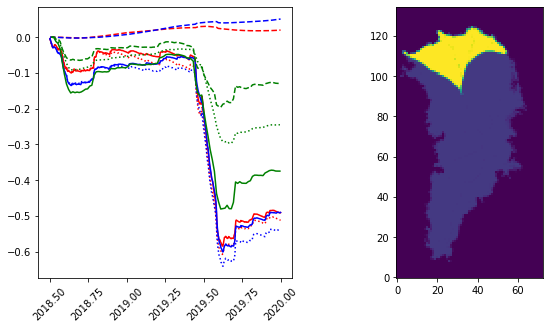

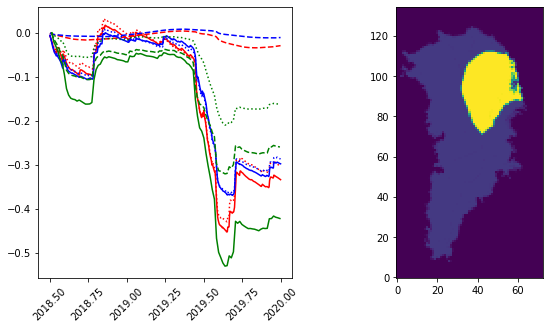

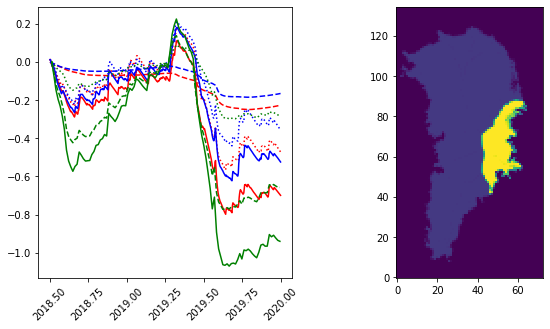

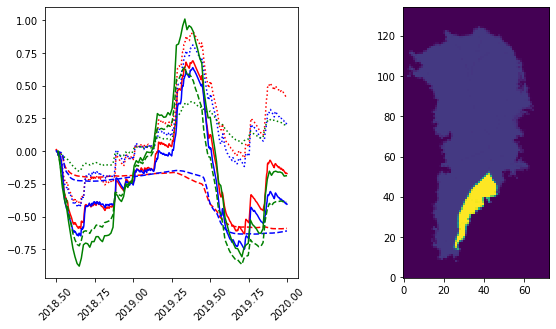

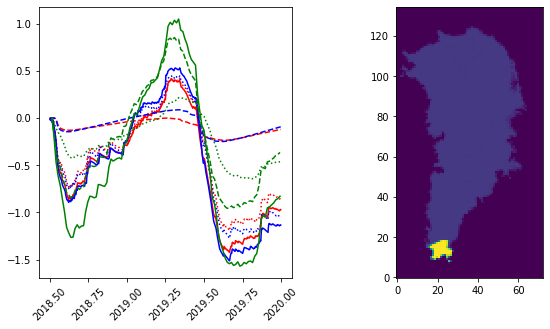

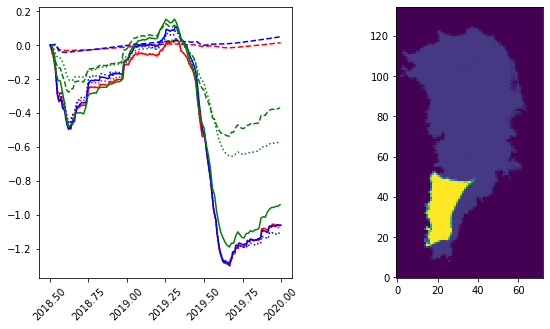

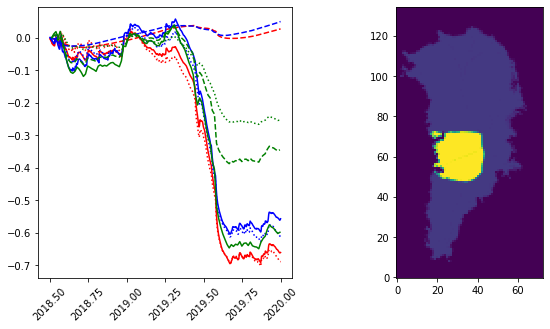

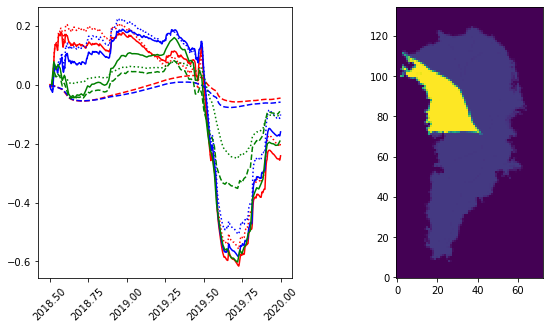

In [147]:
plt_models=['MAR6km_ERA', 'MAR20km_NCEP1']
model_colors=['r','b','g']
components=['DHDT_compaction', 'DHDT_SMB','DHDT_total']
component_styles=['--',':','-']

dh_timseries={}
for model in plt_models+['GSFC']:
    dh_timseries[model]={}
    for basin in range(1,9):
        dh_timseries[model][basin]={}
            
for basin in np.arange(1,9):
    plt.figure(basin, figsize=[10, 5]); plt.clf(); 
    plt.subplot(121)

    for mi, key in enumerate(plt_models):
        basin_i=np.flatnonzero(np.floor(sub_basins)==basin)
        basin_slice=slice(basin_i[0], basin_i[-1]+1)
        years=np.array(ds[key]['time'])/365.25+1980 
        t_i = (years > 2018.5 ) & (years < 2020 )
        i_1996 = np.argmin(np.abs(np.array(ds[key]['time'])/365.25+1980 - 1996))
        for ci, component in enumerate(components):
            dM_i=np.array(ds[key][component])[:,basin_slice].mean(axis=1)
            dM_i -= np.mean(dM_i[0:i_1996])
            plt.plot(np.array(ds[key]['time'])[t_i]/365.25+1980, \
                 np.cumsum(dM_i[t_i]), component_styles[ci], color=model_colors[mi], label=key+' '+component)
            M_i=np.cumsum(dM_i)
        for epoch in epochs:
            this_trange = t_ranges['MARv3_11_2_NCEP_20km_zsurf'][epoch]
            els0 = (years > this_trange[0][0]) & (years < this_trange[0][1])
            els1 = (years > this_trange[1][0]) & (years <  this_trange[1][1])
            dh_timseries[key][basin][epoch] = np.mean(M_i[els1])-np.mean(M_i[els0])
    # plot GSFC:
    for ci, component in enumerate(components):
        temp=np.mean(np.array(me['ds'][me['components'][ci]])[basin_slice,:], axis=0).ravel()[me['t_sub']]
        plt.plot(me['year'][me['t_sub']], temp-temp[0], component_styles[ci], color='g')
    years=me['year'][me['t_sub']]
    
    for epoch in epochs:
        dM_i = np.mean(np.array(me['ds']['height'])[basin_slice,:], axis=0).ravel()[me['t_sub']]
        this_trange = t_ranges['MARv3_11_2_NCEP_20km_zsurf'][epoch]
        els0 = (years > this_trange[0][0]) & (years < this_trange[0][1])
        els1 = (years > this_trange[1][0]) & (years < this_trange[1][1])                                          
        dh_timseries['GSFC'][basin][epoch] = np.mean(dM_i[els1])-np.mean(dM_i[els0])    
        
    plt.xticks(rotation=45)
    
    plt.subplot(122)
    plt.imshow(np.sum(ds[key]['BASIN_MSK'], axis=0) + 5*np.sum(ds[key]['BASIN_MSK'][basin_slice,:,:], axis=0), origin='lower')

In [171]:
dh_timseries['GSFC'][4]

{'2018.Q4-2019.Q2': 1.2272784,
 '2019.Q1-2019.Q2': 0.6946478,
 '2019.Q2-2019.Q3': -1.4214946,
 '2019.Q3-2019.Q4': 0.3742956,
 '2019.Q4-2020.Q1': 0.18407726}

In [172]:
dh_model_mean_pt['GSFC_fdm_v1_zsurf'][4]

{'2018.Q4-2019.Q2': 0.3554072074318009,
 '2019.Q1-2019.Q2': 0.19433439276694367,
 '2019.Q2-2019.Q3': -0.704184656304328,
 '2019.Q3-2019.Q4': 0.07078390080446825,
 '2019.Q4-2020.Q1': nan}

In [188]:
D.keys()

dict_keys(['GSFC_fdm_v1_zsurf', 'MARv3_11_2_ERA_10km_zsurf', 'MARv3_11_2_NCEP_20km_zsurf'])

In [197]:
dh_model_mean_pt['GSFC_fdm_v1_zsurf'][6]

{'2018.Q4-2019.Q2': 0.13047531592337858,
 '2019.Q1-2019.Q2': -0.06648260935704203,
 '2019.Q2-2019.Q3': -0.9786404979090954,
 '2019.Q3-2019.Q4': 0.0376122623919886,
 '2019.Q4-2020.Q1': nan}

In [198]:
dh_model_mean_pt['MARv3_11_2_ERA_10km_zsurf'][6]

{'2018.Q4-2019.Q2': 0.2974031279918057,
 '2019.Q1-2019.Q2': 0.07052444841540334,
 '2019.Q2-2019.Q3': -1.000279331822287,
 '2019.Q3-2019.Q4': 0.12197796174963271,
 '2019.Q4-2020.Q1': nan}

In [208]:
dh_model_mean_pt['GSFC_fdm_v1_zsurf'][2]

{'2018.Q4-2019.Q2': -0.02251465628429301,
 '2019.Q1-2019.Q2': -0.027735701136774402,
 '2019.Q2-2019.Q3': -0.3381295298322166,
 '2019.Q3-2019.Q4': 0.0321609831165564,
 '2019.Q4-2020.Q1': nan}

In [168]:
dh_model_mean_pt['MARv3_11_2_NCEP_20km_zsurf'][2]

{'2018.Q4-2019.Q2': 0.0443190634938842,
 '2019.Q1-2019.Q2': 0.013516326119643233,
 '2019.Q2-2019.Q3': -0.3593076764884202,
 '2019.Q3-2019.Q4': 0.019477056083639206,
 '2019.Q4-2020.Q1': 0.062298330647546585}

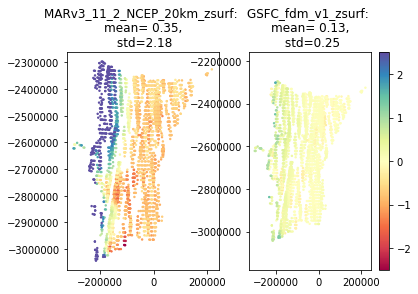

In [210]:
plt.figure();
for count, field in enumerate(['MARv3_11_2_NCEP_20km_zsurf', 'GSFC_fdm_v1_zsurf']):
#
    temp=D[field]['2018.Q4-2019.Q2'].copy()
    temp.index(np.floor(temp.basin)==6)
    ii=np.argsort(temp.dh_model)

    plt.gcf().add_subplot(1,2, count+1)
    plt.scatter(temp.x[ii], temp.y[ii], 2, c=temp.dh_model[ii], cmap='Spectral', vmin=-2.5, vmax=2.5)
    plt.axis('equal')
    plt.title('%s: \nmean= %3.2f,\n std=%3.2f' % (field, np.mean(temp.dh_model[ii]), np.std(temp.dh_model[ii])))
plt.colorbar()

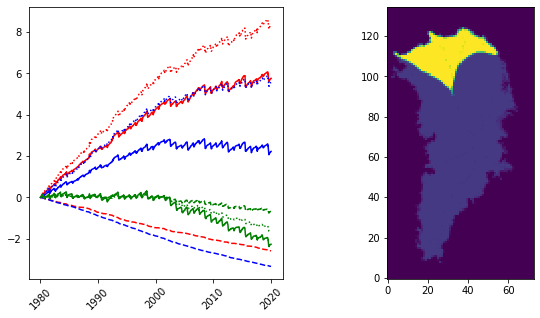

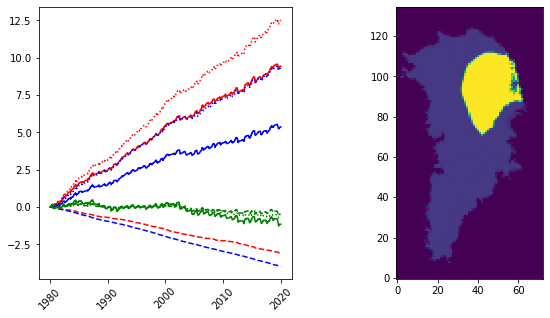

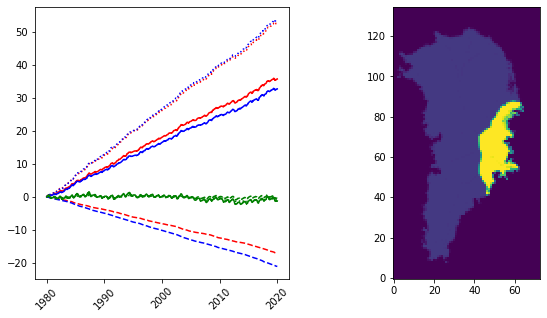

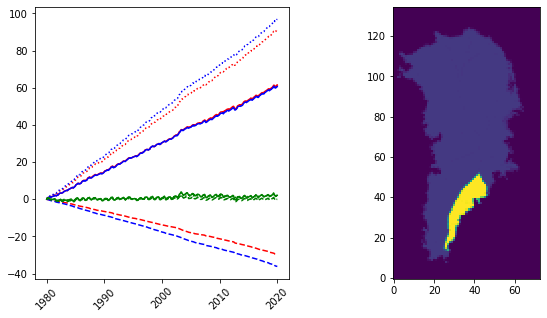

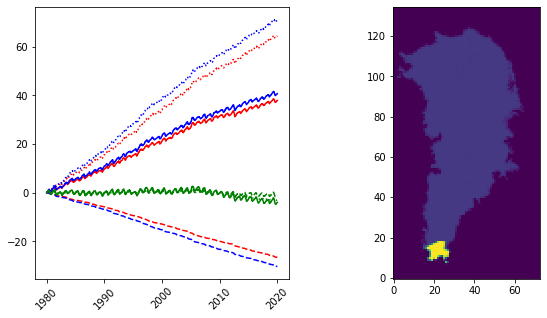

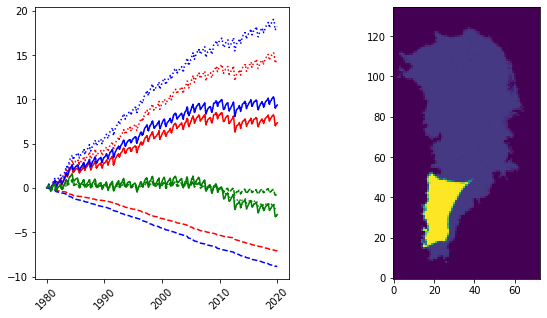

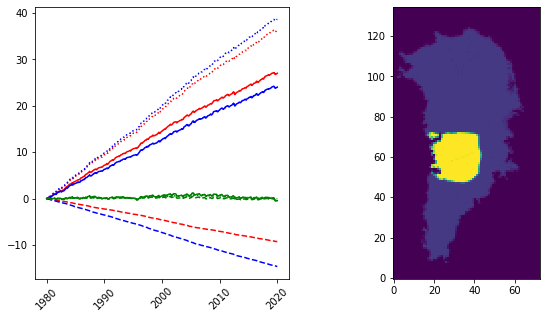

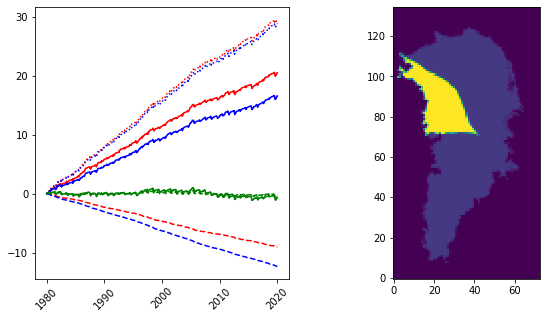

In [7]:

# get the gsfc history
me={}
me['ds'] = nc.Dataset('/home/ben/git_repos/SMBcorr/time_history/merra_hybrid_v1.1/basin_hist.nc','r')
me['components']=['FAC', 'cum_smb_anomaly','height']
me['year'] = np.array(me['ds']['time'])
component_styles=['--',':','-']
me['t_sub']= me['year']> 1018.5
me['basin'] = me['ds']['basin']


plt_models=['MAR6km_ERA', 'MAR20km_NCEP1']
model_colors=['r','b','g']
components=['DHDT_compaction', 'DHDT_SMB','DHDT_total']
component_styles=['--',':','-']

for basin in np.arange(1,9):
    plt.figure(basin, figsize=[10, 5]); plt.clf(); 
    plt.subplot(121)

    for mi, key in enumerate(plt_models):
        basin_i=np.flatnonzero(np.floor(sub_basins)==basin)
        basin_slice=slice(basin_i[0], basin_i[-1]+1)
        t_i=(np.array(ds[key]['time'])/365.25+1980 > 1018.5 ) & (np.array(ds[key]['time'])/365.25+1980 < 2020 )
        i_1996 = np.argmin(np.abs(np.array(ds[key]['time'])/365.25+1980 - 1996))
        for ci, component in enumerate(components):
            dM_i=np.array(ds[key][component])[:,basin_slice].mean(axis=1)
            #dM_i -= np.mean(dM_i[0:i_1996])
            plt.plot(np.array(ds[key]['time'])[t_i]/365.25+1980, \
                 np.cumsum(dM_i[t_i]), component_styles[ci], color=model_colors[mi], label=key+' '+component)
    # plot GSFC:
    for ci, component in enumerate(components):
        temp=np.mean(np.array(me['ds'][me['components'][ci]])[basin_slice,:], axis=0).ravel()[me['t_sub']]
        plt.plot(me['year'][me['t_sub']], temp-temp[0], component_styles[ci], color='g')
    plt.xticks(rotation=45)
    
    plt.subplot(122)
    plt.imshow(np.sum(ds[key]['BASIN_MSK'], axis=0) + 5*np.sum(ds[key]['BASIN_MSK'][basin_slice,:,:], axis=0), origin='lower')